In [1]:
#pip install matplotlib
#!pip install scikit-learn #ensures it's installed in the correct env
#pip install -U scikit-learn

In [2]:
#imports only
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, RandomizedSearchCV
from scipy import stats
import sklearn.preprocessing as skl_pre
import sklearn.linear_model as skl_lm
import sklearn.discriminant_analysis as skl_da
import sklearn.neighbors as skl_nb
from sklearn.ensemble import RandomForestClassifier
from scipy import stats
import seaborn as sns
from pandas.plotting import scatter_matrix


In [3]:
file_path = 'siren_data_train.csv'
data = pd.read_csv(file_path)

#Split the binary columns into zeroes and ones and use that going forwards
data = pd.get_dummies(data, columns=["building","noise", "in_vehicle", "asleep","no_windows"])
data_copy = data.copy()

data.head()

,near_fid,near_x,near_y,near_angle,heard,xcoor,ycoor,age,building_0,building_1,noise_0,noise_1,in_vehicle_0,in_vehicle_1,asleep_0,asleep_1,no_windows_0,no_windows_1
0,2712,1.998301e+06,9.011692e+06,-171.588672,1,1999193.0,9011824,59,1,0,1,0,1,0,1,0,1,0
1,2721,1.928907e+06,8.954624e+06,-51.208102,1,1928298.0,8955382,29,1,0,1,0,1,0,1,0,1,0
2,297,2.026384e+06,8.256164e+06,39.018754,1,2025706.0,8255615,32,1,0,1,0,1,0,1,0,1,0
3,739,1.743184e+06,8.052652e+06,15.046022,1,1742935.0,8052585,36,1,0,1,0,1,0,1,0,1,0
4,1852,1.350375e+06,7.909850e+06,144.603170,1,1350807.0,7909543,55,1,0,1,0,1,0,1,0,1,0


In [4]:
data.describe()

,near_fid,near_x,near_y,near_angle,heard,xcoor,ycoor,age,building_0,building_1,noise_0,noise_1,in_vehicle_0,in_vehicle_1,asleep_0,asleep_1,no_windows_0,no_windows_1
count,5710.000000,5.710000e+03,5.710000e+03,5710.000000,5710.000000,5.710000e+03,5.710000e+03,5710.000000,5710.000000,5710.000000,5710.000000,5710.000000,5710.000000,5710.000000,5710.000000,5710.000000,5710.000000,5710.000000
mean,1888.705954,1.797385e+06,8.283496e+06,1.751993,0.760070,1.796497e+06,8.283723e+06,50.635902,0.751313,0.248687,0.809107,0.190893,0.905954,0.094046,0.993870,0.006130,0.976357,0.023643
std,1320.046217,2.783430e+05,5.363099e+05,106.216736,0.427078,2.789790e+05,5.369782e+05,18.630865,0.432290,0.432290,0.393039,0.393039,0.291918,0.291918,0.078058,0.078058,0.151947,0.151947
min,1.000000,1.244070e+06,7.430582e+06,-179.786267,0.000000,1.244893e+06,7.432236e+06,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,538.000000,1.535191e+06,7.919606e+06,-90.278514,1.000000,1.529848e+06,7.919276e+06,35.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000
50%,1901.000000,1.895376e+06,8.251327e+06,2.313685,1.000000,1.891302e+06,8.251345e+06,50.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000
75%,2821.000000,2.003408e+06,8.368423e+06,95.330994,1.000000,2.003743e+06,8.368852e+06,66.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000
max,4150.000000,2.686771e+06,1.040622e+07,179.992043,1.000000,2.686256e+06,1.042743e+07,88.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# Create new features - distance, age group and distance group

### Create age group

#### Created new age buckets based on:
https://www.nidcd.nih.gov/health/statistics/hearing-loss-increases-with-age


![title](hearing_w_age.png)

In [5]:

#original bins
#age_bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
#age_labels = ['0-10', '10-20', '20-30', '30-40', '40-50', '50-60', '60-70', '70-80', '80-90', '90-100']

# Create age groups column
#data['age_group'] = pd.cut(data['age'], bins=age_bins, labels=age_labels, right=False)

#new bins based on hearing with age
new_age_bins = [0, 40, 50, 60, 70, float('inf')]
new_age_labels = ['0-39', '40-49', '50-59', '60-69', '70+']

# Create age groups column with new bins
data['age_group'] = pd.cut(data['age'], bins=new_age_bins, labels=new_age_labels, right=False)



In [6]:
data

,near_fid,near_x,near_y,near_angle,heard,xcoor,ycoor,age,building_0,building_1,noise_0,noise_1,in_vehicle_0,in_vehicle_1,asleep_0,asleep_1,no_windows_0,no_windows_1,age_group
0,2712,1.998301e+06,9.011692e+06,-171.588672,1,1999193.0,9011824,59,1,0,1,0,1,0,1,0,1,0,50-59
1,2721,1.928907e+06,8.954624e+06,-51.208102,1,1928298.0,8955382,29,1,0,1,0,1,0,1,0,1,0,0-39
2,297,2.026384e+06,8.256164e+06,39.018754,1,2025706.0,8255615,32,1,0,1,0,1,0,1,0,1,0,0-39
3,739,1.743184e+06,8.052652e+06,15.046022,1,1742935.0,8052585,36,1,0,1,0,1,0,1,0,1,0,0-39
4,1852,1.350375e+06,7.909850e+06,144.603170,1,1350807.0,7909543,55,1,0,1,0,1,0,1,0,1,0,50-59
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5705,5,2.008871e+06,8.255775e+06,-176.234663,1,2009140.0,8255793,29,1,0,1,0,1,0,1,0,1,0,0-39
5706,4069,1.981871e+06,8.270452e+06,45.691415,1,1981119.0,8269682,49,1,0,1,0,1,0,1,0,1,0,40-49
5707,2170,1.463760e+06,8.074997e+06,-175.473118,1,1464308.0,8075040,62,1,0,1,0,1,0,1,0,1,0,60-69
5708,1591,1.479843e+06,7.526377e+06,142.958054,1,1480125.0,7526164,37,1,0,1,0,1,0,1,0,1,0,0-39


### Create distance

In [7]:
#add distance to horn
# Calculate Euclidean distance between person and nearest horn
data['dist'] = np.sqrt((data['xcoor'] - data['near_x'])**2 + (data['ycoor'] - data['near_y'])**2)


### Create distance group

In [8]:

# Add distance groups
# Create bins for distance ranging from 0 to 3000 with a step size of 100
step_size = 500
distance_bins = np.arange(0, 3100, step_size)

# Create labels for distance bins
distance_labels = [f'{i}-{i+step_size}' for i in range(0, 3000, step_size)]
# Append a bin edge for values greater than 3000
distance_bins = np.append(distance_bins, np.inf)
distance_labels.append('>3000')

# Assign each distance value to a corresponding bin
data['distance_groups'] = pd.cut(data['dist'], bins=distance_bins, labels=distance_labels, right=False)

### Check data

In [9]:
data.head()

,near_fid,near_x,near_y,near_angle,heard,xcoor,ycoor,age,building_0,building_1,...,noise_1,in_vehicle_0,in_vehicle_1,asleep_0,asleep_1,no_windows_0,no_windows_1,age_group,dist,distance_groups
0,2712,1.998301e+06,9.011692e+06,-171.588672,1,1999193.0,9011824,59,1,0,...,0,1,0,1,0,1,0,50-59,901.283517,500-1000
1,2721,1.928907e+06,8.954624e+06,-51.208102,1,1928298.0,8955382,29,1,0,...,0,1,0,1,0,1,0,0-39,972.006260,500-1000
2,297,2.026384e+06,8.256164e+06,39.018754,1,2025706.0,8255615,32,1,0,...,0,1,0,1,0,1,0,0-39,872.340924,500-1000
3,739,1.743184e+06,8.052652e+06,15.046022,1,1742935.0,8052585,36,1,0,...,0,1,0,1,0,1,0,0-39,257.804449,0-500
4,1852,1.350375e+06,7.909850e+06,144.603170,1,1350807.0,7909543,55,1,0,...,0,1,0,1,0,1,0,50-59,529.686791,500-1000


# Generate dummies for newly created categorical data but keep original columns for the plots later

In [10]:
dummies = pd.get_dummies(data, columns=["age_group", "distance_groups", "heard"])

keep_these_original_columns_for_plots = data[["heard", "distance_groups", "age_group"]]

data = pd.concat([keep_these_original_columns_for_plots, dummies], axis=1)

data_copy = data.copy()


In [11]:
data.head()

,heard,distance_groups,age_group,near_fid,near_x,near_y,near_angle,xcoor,ycoor,age,...,age_group_70+,distance_groups_0-500,distance_groups_500-1000,distance_groups_1000-1500,distance_groups_1500-2000,distance_groups_2000-2500,distance_groups_2500-3000,distance_groups_>3000,heard_0,heard_1
0,1,500-1000,50-59,2712,1.998301e+06,9.011692e+06,-171.588672,1999193.0,9011824,59,...,0,0,1,0,0,0,0,0,0,1
1,1,500-1000,0-39,2721,1.928907e+06,8.954624e+06,-51.208102,1928298.0,8955382,29,...,0,0,1,0,0,0,0,0,0,1
2,1,500-1000,0-39,297,2.026384e+06,8.256164e+06,39.018754,2025706.0,8255615,32,...,0,0,1,0,0,0,0,0,0,1
3,1,0-500,0-39,739,1.743184e+06,8.052652e+06,15.046022,1742935.0,8052585,36,...,0,1,0,0,0,0,0,0,0,1
4,1,500-1000,50-59,1852,1.350375e+06,7.909850e+06,144.603170,1350807.0,7909543,55,...,0,0,1,0,0,0,0,0,0,1


# Generating samples

In [12]:
#random sampling
def split_train_test(data, test_ratio): 
    shuffled_indices = np.random.permutation(len(data)) #creates array of indices that are randomly shuffled
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

#stratified sampling, where we create a sample that takes the distribution of age into account
def stratified_sampling(data, test_ratio, important_data_column):
    split = StratifiedShuffleSplit(n_splits=1, test_size = test_ratio, random_state=42)
    for train_index, test_index in split.split(data, important_data_column):
        strat_train_set = data.loc[train_index]
        strat_test_set = data.loc[test_index]
    return strat_train_set, strat_test_set


#create samples
train, test = stratified_sampling(data, 0.2, data["age"])
#print(len(test_set))
#print(len(train_set))

In [13]:
train


,heard,distance_groups,age_group,near_fid,near_x,near_y,near_angle,xcoor,ycoor,age,...,age_group_70+,distance_groups_0-500,distance_groups_500-1000,distance_groups_1000-1500,distance_groups_1500-2000,distance_groups_2000-2500,distance_groups_2500-3000,distance_groups_>3000,heard_0,heard_1
5314,0,>3000,60-69,2826,1.903935e+06,9.632390e+06,-38.979563,1699234.0,9798032,68,...,0,0,0,0,0,0,0,1,1,0
2479,0,500-1000,40-49,2373,1.568945e+06,8.245640e+06,-66.915275,1568722.0,8246164,44,...,0,0,1,0,0,0,0,0,1,0
4309,0,>3000,40-49,2678,1.908912e+06,8.556700e+06,-114.469282,1910922.0,8561117,47,...,0,0,0,0,0,0,0,1,1,0
2679,1,>3000,0-39,698,1.917086e+06,8.237269e+06,59.752139,1914948.0,8233603,24,...,0,0,0,0,0,0,0,1,0,1
2422,1,500-1000,70+,1820,1.325982e+06,7.907037e+06,-151.158248,1326551.0,7907350,70,...,1,0,1,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
423,1,500-1000,0-39,2808,1.627275e+06,9.145380e+06,68.474925,1627051.0,9144812,31,...,0,0,1,0,0,0,0,0,0,1
3946,1,500-1000,60-69,1701,1.365743e+06,7.782783e+06,109.740636,1365994.0,7782085,67,...,0,0,1,0,0,0,0,0,0,1
3463,0,500-1000,40-49,265,2.003937e+06,8.259866e+06,-113.103453,2004316.0,8260755,48,...,0,0,1,0,0,0,0,0,1,0
3789,0,>3000,70+,1038,1.667253e+06,7.898686e+06,-135.186438,1699896.0,7931118,88,...,1,0,0,0,0,0,0,1,1,0


In [14]:
test

,heard,distance_groups,age_group,near_fid,near_x,near_y,near_angle,xcoor,ycoor,age,...,age_group_70+,distance_groups_0-500,distance_groups_500-1000,distance_groups_1000-1500,distance_groups_1500-2000,distance_groups_2000-2500,distance_groups_2500-3000,distance_groups_>3000,heard_0,heard_1
5274,1,500-1000,70+,2566,1.752774e+06,8.532811e+06,-32.317315,1752020.0,8533288,78,...,1,0,1,0,0,0,0,0,0,1
3772,1,0-500,0-39,742,1.727620e+06,8.054662e+06,-148.946005,1727716.0,8054720,19,...,0,1,0,0,0,0,0,0,0,1
3335,0,>3000,60-69,2807,1.597914e+06,8.868453e+06,-60.606710,1543123.0,8965717,61,...,0,0,0,0,0,0,0,1,1,0
2942,0,0-500,70+,42,2.011085e+06,8.254681e+06,42.482666,2010867.0,8254481,79,...,1,1,0,0,0,0,0,0,1,0
1589,1,500-1000,50-59,529,1.961417e+06,8.372456e+06,70.820382,1961222.0,8371896,51,...,0,0,1,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3805,1,500-1000,0-39,2315,1.524405e+06,8.408680e+06,38.082058,1523896.0,8408282,32,...,0,0,1,0,0,0,0,0,0,1
5644,1,0-500,0-39,4113,1.373116e+06,8.045137e+06,-121.963832,1373226.0,8045313,35,...,0,1,0,0,0,0,0,0,0,1
2022,1,0-500,60-69,173,2.005384e+06,8.237367e+06,149.006320,2005792.0,8237122,63,...,0,1,0,0,0,0,0,0,0,1
1514,0,>3000,40-49,473,1.978581e+06,8.338759e+06,47.978864,1974378.0,8334094,43,...,0,0,0,0,0,0,0,1,1,0


In [15]:
#compare performances, stratified sampling is better for age group

import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit

def split_comparison(data, target_column, test_size=0.2, random_state=None):
    # Original data overall performance
    overall_performance = data[target_column].value_counts(normalize=True)
    
    # Stratified Sampling
    split = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=random_state)
    for train_index, test_index in split.split(data, data[target_column]):
        strat_train_set = data.loc[train_index]
        strat_test_set = data.loc[test_index]
    
    # Random Sampling
    rand_train_set, rand_test_set = train_test_split(data, test_size=test_size, random_state=random_state)
    
    # Calculate performance metrics for stratified sampling
    strat_train_performance = strat_train_set[target_column].value_counts(normalize=True)
    strat_test_performance = strat_test_set[target_column].value_counts(normalize=True)
    
    # Calculate performance metrics for random sampling
    rand_train_performance = rand_train_set[target_column].value_counts(normalize=True)
    rand_test_performance = rand_test_set[target_column].value_counts(normalize=True)
    
    # Calculate percentage error
    strat_train_error = ((strat_train_performance - overall_performance) / overall_performance) * 100
    strat_test_error = ((strat_test_performance - overall_performance) / overall_performance) * 100
    
    rand_train_error = ((rand_train_performance - overall_performance) / overall_performance) * 100
    rand_test_error = ((rand_test_performance - overall_performance) / overall_performance) * 100
    
    # Create comparison table
    comparison_df = pd.DataFrame({
        'Overall performance': overall_performance,
        'Stratified': strat_test_performance,
        'Random': rand_test_performance,
        'Strat. % error': strat_test_error,
        'Rand. % error': rand_test_error
    })
    
    return comparison_df

# Example usage:
comparison_table = split_comparison(data, target_column='age', test_size=0.2, random_state=42)
print(comparison_table)


    Overall performance  Stratified    Random  Strat. % error  Rand. % error
18             0.011033    0.011384  0.017513        3.174603      58.730159
19             0.012434    0.012259  0.014011       -1.408451      12.676056
20             0.012434    0.012259  0.008757       -1.408451     -29.577465
21             0.015762    0.015762  0.017513        0.000000      11.111111
22             0.012960    0.013135  0.014886        1.351351      14.864865
..                  ...         ...       ...             ...            ...
84             0.002977    0.002627  0.004378      -11.764706      47.058824
85             0.005429    0.005254  0.004378       -3.225806     -19.354839
86             0.003853    0.003503  0.004378       -9.090909      13.636364
87             0.003678    0.003503  0.003503       -4.761905      -4.761905
88             0.002977    0.002627  0.001751      -11.764706     -41.176471

[71 rows x 5 columns]


# Which features shall we include?

#### Drop some columns to easier filter out whats important

In [16]:
data.head()

,heard,distance_groups,age_group,near_fid,near_x,near_y,near_angle,xcoor,ycoor,age,...,age_group_70+,distance_groups_0-500,distance_groups_500-1000,distance_groups_1000-1500,distance_groups_1500-2000,distance_groups_2000-2500,distance_groups_2500-3000,distance_groups_>3000,heard_0,heard_1
0,1,500-1000,50-59,2712,1.998301e+06,9.011692e+06,-171.588672,1999193.0,9011824,59,...,0,0,1,0,0,0,0,0,0,1
1,1,500-1000,0-39,2721,1.928907e+06,8.954624e+06,-51.208102,1928298.0,8955382,29,...,0,0,1,0,0,0,0,0,0,1
2,1,500-1000,0-39,297,2.026384e+06,8.256164e+06,39.018754,2025706.0,8255615,32,...,0,0,1,0,0,0,0,0,0,1
3,1,0-500,0-39,739,1.743184e+06,8.052652e+06,15.046022,1742935.0,8052585,36,...,0,1,0,0,0,0,0,0,0,1
4,1,500-1000,50-59,1852,1.350375e+06,7.909850e+06,144.603170,1350807.0,7909543,55,...,0,0,1,0,0,0,0,0,0,1


In [17]:
mini_data = data.copy().drop(columns=["near_fid", "near_y", "near_x", "xcoor", "ycoor"], inplace=False)

### Check correlations

In [18]:
corr_matrix = mini_data.corr()
corr_matrix["heard_1"].sort_values(ascending=False)

heard                        1.000000
heard_1                      1.000000
in_vehicle_0                 0.406263
noise_0                      0.400162
distance_groups_0-500        0.317595
no_windows_0                 0.239178
distance_groups_500-1000     0.208581
age_group_0-39               0.197279
asleep_0                     0.139777
distance_groups_1000-1500    0.083388
building_1                   0.063283
age_group_40-49              0.063257
distance_groups_1500-2000    0.028361
near_angle                   0.006788
distance_groups_2000-2500    0.004256
age_group_50-59             -0.004487
distance_groups_2500-3000   -0.015979
age_group_60-69             -0.060252
building_0                  -0.063283
asleep_1                    -0.139777
age_group_70+               -0.233675
no_windows_1                -0.239178
age                         -0.288908
noise_1                     -0.400162
in_vehicle_1                -0.406263
dist                        -0.564778
distance_gro

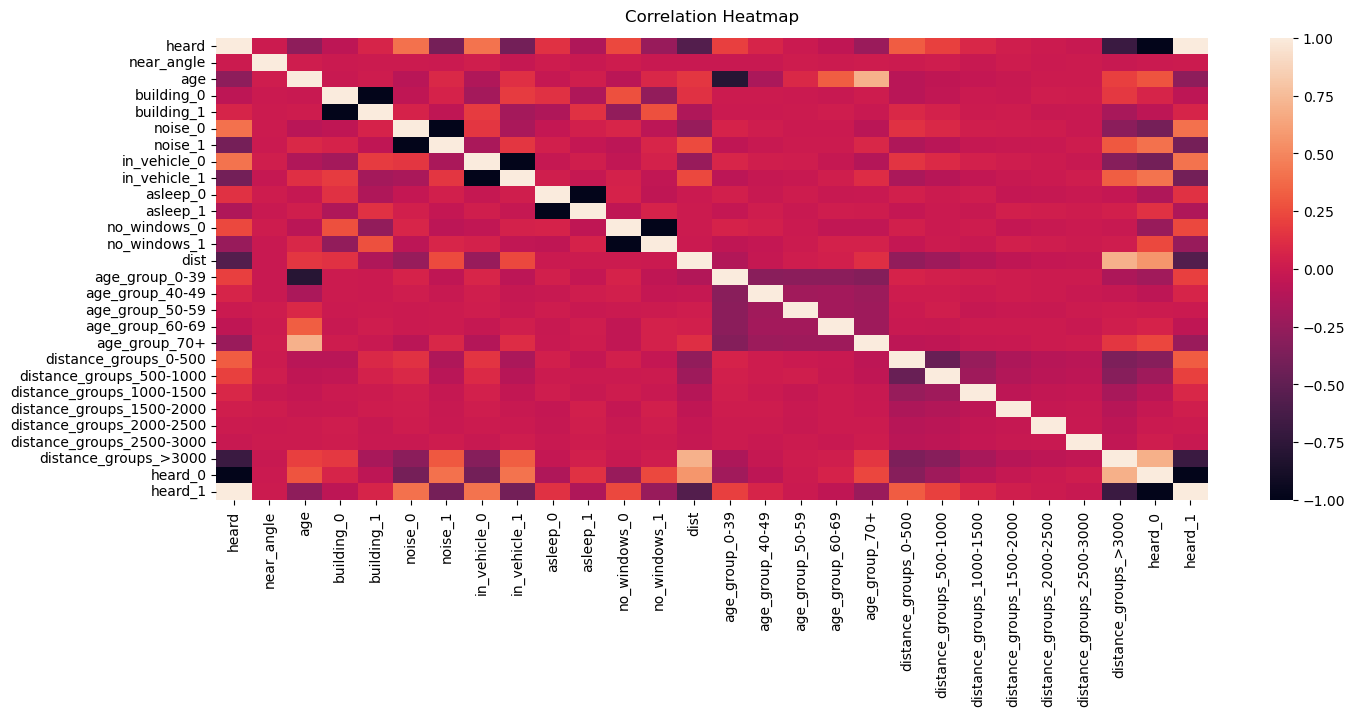

In [19]:
#sns.heatmap(mini_data.corr());

# Increase the size of the heatmap.
plt.figure(figsize=(16, 6))
# Store heatmap object in a variable to easily access it when you want to include more features (such as title).
# Set the range of values to be displayed on the colormap from -1 to 1, and set the annotation to True to display the correlation values on the heatmap.
heatmap = sns.heatmap(mini_data.corr(), vmin=-1, vmax=1, annot=False)
# Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

### From the above heatmap, we can see that these features positively affects heard_1:
Being in a building, not having any noise, not being in a vehicle, not being asleet (slight corr), to have windows, and being in the agegroup 0-50 y/o along with being 0-1000 (metres?) away from the horn




# Set X_train, X_test, y_train and y_test

In [20]:
#drop categorical values 
train = train.drop(columns=["distance_groups", "age_group"], axis=1)
test = test.drop(columns=["distance_groups", "age_group"], axis=1)

In [21]:
#right now we have all features, pls change

X_train = train.drop(columns=['heard', "heard_0", "heard_1"])
y_train = train['heard']

# Extract features and target for testing set
X_test = test.drop(columns=['heard', "heard_0", "heard_1"])
y_test = test['heard']


In [22]:
X_train

,near_fid,near_x,near_y,near_angle,xcoor,ycoor,age,building_0,building_1,noise_0,...,age_group_50-59,age_group_60-69,age_group_70+,distance_groups_0-500,distance_groups_500-1000,distance_groups_1000-1500,distance_groups_1500-2000,distance_groups_2000-2500,distance_groups_2500-3000,distance_groups_>3000
5314,2826,1.903935e+06,9.632390e+06,-38.979563,1699234.0,9798032,68,1,0,0,...,0,1,0,0,0,0,0,0,0,1
2479,2373,1.568945e+06,8.245640e+06,-66.915275,1568722.0,8246164,44,0,1,0,...,0,0,0,0,1,0,0,0,0,0
4309,2678,1.908912e+06,8.556700e+06,-114.469282,1910922.0,8561117,47,1,0,0,...,0,0,0,0,0,0,0,0,0,1
2679,698,1.917086e+06,8.237269e+06,59.752139,1914948.0,8233603,24,1,0,1,...,0,0,0,0,0,0,0,0,0,1
2422,1820,1.325982e+06,7.907037e+06,-151.158248,1326551.0,7907350,70,0,1,1,...,0,0,1,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
423,2808,1.627275e+06,9.145380e+06,68.474925,1627051.0,9144812,31,1,0,1,...,0,0,0,0,1,0,0,0,0,0
3946,1701,1.365743e+06,7.782783e+06,109.740636,1365994.0,7782085,67,1,0,1,...,0,1,0,0,1,0,0,0,0,0
3463,265,2.003937e+06,8.259866e+06,-113.103453,2004316.0,8260755,48,0,1,1,...,0,0,0,0,1,0,0,0,0,0
3789,1038,1.667253e+06,7.898686e+06,-135.186438,1699896.0,7931118,88,1,0,1,...,0,0,1,0,0,0,0,0,0,1


In [23]:
y_train

5314    0
2479    0
4309    0
2679    1
2422    1
       ..
423     1
3946    1
3463    0
3789    0
2531    1
Name: heard, Length: 4568, dtype: int64

# (i) Does the distance to the nearest horn affect whether a person hears the siren or not?

In [24]:
data.columns

Index(['heard', 'distance_groups', 'age_group', 'near_fid', 'near_x', 'near_y',
       'near_angle', 'xcoor', 'ycoor', 'age', 'building_0', 'building_1',
       'noise_0', 'noise_1', 'in_vehicle_0', 'in_vehicle_1', 'asleep_0',
       'asleep_1', 'no_windows_0', 'no_windows_1', 'dist', 'age_group_0-39',
       'age_group_40-49', 'age_group_50-59', 'age_group_60-69',
       'age_group_70+', 'distance_groups_0-500', 'distance_groups_500-1000',
       'distance_groups_1000-1500', 'distance_groups_1500-2000',
       'distance_groups_2000-2500', 'distance_groups_2500-3000',
       'distance_groups_>3000', 'heard_0', 'heard_1'],
      dtype='object')

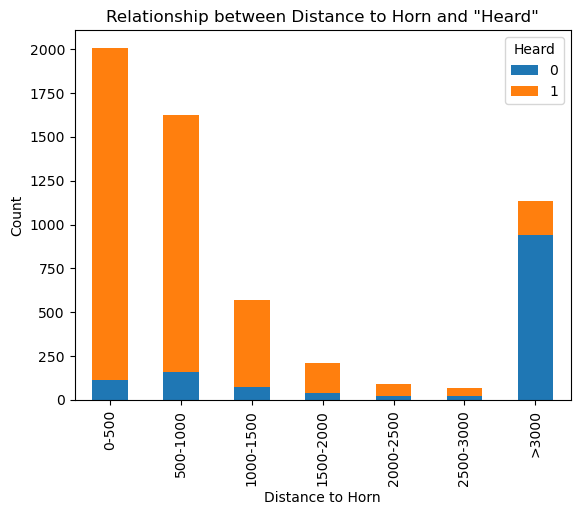

In [25]:
#Comparing distance and heard

#temp_data = data_copy

# Create stacked bar chart
pd.crosstab(data['distance_groups'], data['heard']).plot.bar(stacked=True)
plt.xlabel('Distance to Horn')
plt.ylabel('Count')
plt.title('Relationship between Distance to Horn and "Heard"')
plt.legend(title='Heard')
plt.show()

Text(0, 0.5, 'The procent hearing (%)')

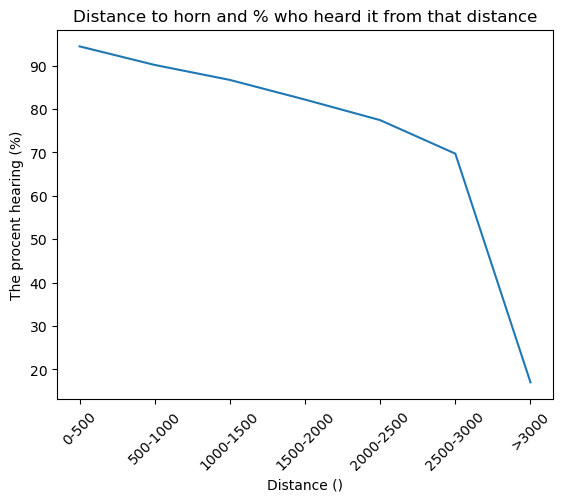

In [26]:
dist_num = data.pivot_table(index = ['distance_groups'], columns= 'heard', aggfunc='size')

dist_num[1] = dist_num[1].fillna(0)
dist_num[0] = dist_num[0].fillna(0)
dist_num_1 = np.array(dist_num[1])
dist_num_0 = np.array(dist_num[0])

dist_procent = (dist_num_1)/(dist_num_1+dist_num_0)*100

index_dist = np.array(dist_num.index)


plt.plot(index_dist, dist_procent)
plt.xlabel('Distance ()')
plt.title("Distance to horn and % who heard it from that distance")
plt.xticks(rotation=45)
plt.ylabel('The procent hearing (%)')

In [ ]:
from scipy import stats

# Split data into two groups based on 'heard' column
heard_group = data[data['heard'] == 1]['dist']
not_heard_group = data[data['heard'] == 0]['dist']


# Visualize distributions (optional)
# Example: sns.histplot(heard_group, label='Heard')
# Example: sns.histplot(not_heard_group, label='Not Heard')
# Add legend, labels, and titles as necessary

# Perform t-test
t_statistic, p_value = stats.ttest_ind(heard_group, not_heard_group)

# Interpret results
alpha = 0.05
if p_value < alpha:
    print("There is a statistically significant difference in the distributions.")
else:
    print("There is no statistically significant difference in the distributions.")


#### Is theren a statistical difference between those that heard the signal and those that didn't given the distance?


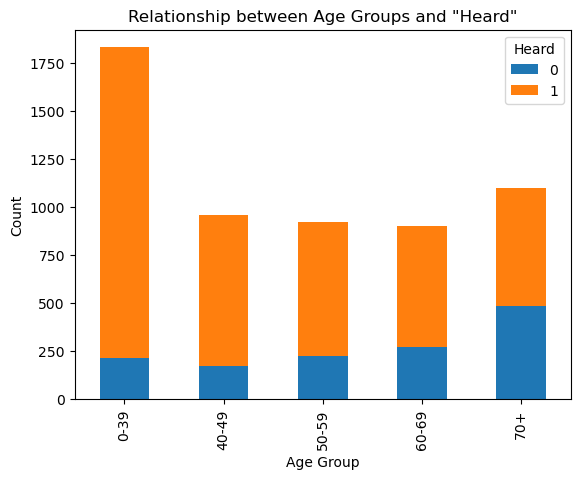

In [27]:

#Comparing age and heard

# Create stacked bar chart
pd.crosstab(data['age_group'], data['heard']).plot.bar(stacked=True)
plt.xlabel('Age Group')
plt.ylabel('Count')
plt.title('Relationship between Age Groups and "Heard"')
plt.legend(title='Heard')
plt.show()

Text(0, 0.5, 'The procent hearing (%)')

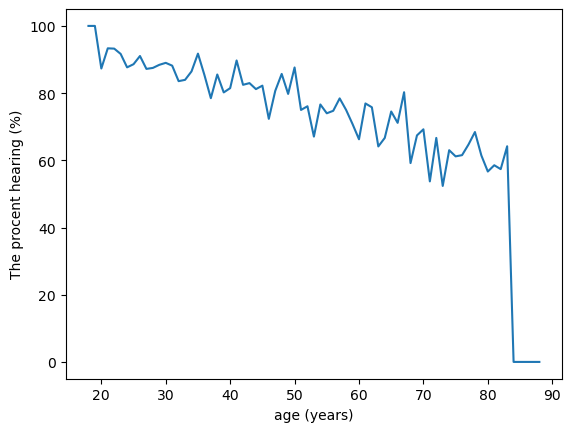

In [28]:
#The relationship between age and hearing
age_num = data_copy.pivot_table(index = ['age'], columns= 'heard', aggfunc='size')

age_num[1] = age_num[1].fillna(0)
age_num[0] = age_num[0].fillna(0)
age_num_1 = np.array(age_num[1])
age_num_0 = np.array(age_num[0])

age_procent = (age_num_1)/(age_num_1+age_num_0)*100 #procent som hör per åldersgrupp

index_age = np.array(age_num.index)

plt.plot(index_age, age_procent)
plt.xlabel('age (years)')
plt.ylabel('The procent hearing (%)')



# (iii) Does the direction towards the nearest horn affect whether a person hears the siren or not?

Text(0, 0.5, 'The procent hearing (%)')

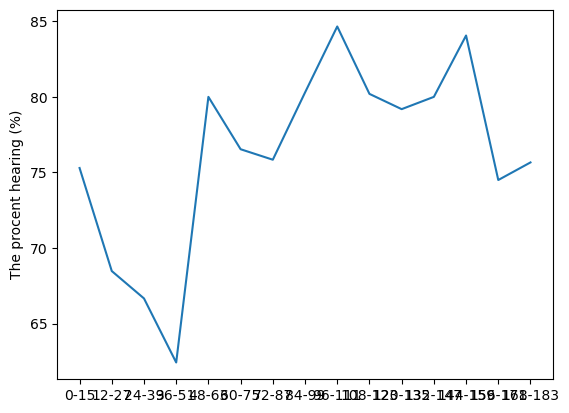

In [29]:
# Create bins for angle ranging from 0 to 2000 with a step size of 100
angle_bins = np.arange(0, 181, 12)

# Create labels for angle bins
angle_labels = [f'{i}-{i+15}' for i in range(0, 180, 12)]

# Assign each angle value to a corresponding bin
data['ange_span'] = pd.cut(data['near_angle'], bins=angle_bins, labels=angle_labels, right=False)

angle_num = data.pivot_table(index = ['ange_span'], columns= 'heard', aggfunc='size')

angle_num_1 = np.array(angle_num[1])
angle_num_0 = np.array(angle_num[0])

angle_procent = (angle_num_1 )/(angle_num_1 +angle_num_0)*100 #procent som hör

index_angle = np.array(angle_num.index)

plt.plot(index_angle, angle_procent)
plt.xlabel('')
plt.ylabel('The procent hearing (%)')


# Random Forest

In [30]:
#Prepering the data for training and validation

data['dist'] = np.sqrt((data.near_x - data.xcoor)**2 + (data.near_y - data.ycoor)**2)

feat = ['near_fid', 'near_x', 'near_y', 'near_angle', 'xcoor', 'ycoor',
       'age', 'building_0', 'building_1', 'noise_0', 'noise_1', 'in_vehicle_0',
       'in_vehicle_1', 'asleep_0', 'asleep_1', 'no_windows_0', 'no_windows_1', 'dist']

x = data[feat] #inputs

y = data.heard # output

x = data[feat] #inputs

y = data['heard'] # output 
train_X, val_X, train_y, val_y = train_test_split(x,y, random_state=0, train_size=0.8)

In [31]:
model_tree = RandomForestClassifier()

par = {'n_estimators': stats.randint(50, 750), 'criterion':['gini', 'entropy'], 'max_depth': [4, 5, 6, 7, 8, 9], 'min_samples_split' : [1,2,3,4, 5, 6]}


RSC = RandomizedSearchCV(model_tree, param_distributions = par, n_iter = 10, cv=5, n_jobs = -1 )

RSC.fit(train_X, train_y)

model_tree = RSC.best_estimator_

model_tree.fit(train_X, train_y)

model_tree_prediction = model_tree.predict(val_X)

print(pd.crosstab(model_tree_prediction, val_y))
print(f"acc: {np.mean(model_tree_prediction == val_y)}")

/Users/Elise/opt/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
5 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/Elise/opt/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/Elise/opt/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py", line 476, in fit
    trees = Parallel(
  File "/Users/Elise/opt/anaconda3/envs/homl3/lib/python3.10/site-packages/joblib/parallel.py", line 1048, in __call__
 

heard    0    1
row_0          
0      192   23
1       60  867
acc: 0.9273204903677759


In [32]:
print(pd.crosstab(model_tree_prediction, val_y))
print(f"acc: {np.mean(model_tree_prediction == val_y)}")

heard    0    1
row_0          
0      192   23
1       60  867
acc: 0.9273204903677759


# LDA and QDA

### LDA

In [33]:
import sklearn.discriminant_analysis as skl_da

In [34]:
lda_model = skl_da.LinearDiscriminantAnalysis()
lda_model.fit(X_train, y_train)

LinearDiscriminantAnalysis()

In [35]:
predict_prob_lda = lda_model.predict_proba(X_test)

print("The class order in the model: ")
print(lda_model.classes_)

print("Examples of predicted probabilities for the above classes: ")
with np.printoptions(suppress=True, precision=6):
    print(predict_prob_lda[0:5])

The class order in the model: 
[0 1]
Examples of predicted probabilities for the above classes: 
[[0.003929 0.996071]
 [0.004468 0.995532]
 [0.999974 0.000026]
 [0.003078 0.996922]
 [0.001018 0.998982]]


In [36]:
prediction_lda = np.empty(len(X_test), dtype=object)
prediction_lda = np.where(predict_prob_lda[:, 0] >= 0.5, 0, 1) #0 is not heard, 1 is heard
print("Five first predictions: ")
print(prediction_lda[0:5], "\n")


# Confusion matrix
print("Confusion matrix: \n")
print(pd.crosstab(prediction_lda, y_test), "\n")

#Accuracy
print(f"Accuracy: {np.mean(prediction_lda == y_test):.3f}")

Five first predictions: 
[1 1 0 1 1] 

Confusion matrix: 

heard    0    1
row_0          
0      207   36
1       61  838 

Accuracy: 0.915


### QDA

In [37]:
qda_model = skl_da.QuadraticDiscriminantAnalysis()
qda_model.fit(X_train, y_train)

/Users/Elise/opt/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/discriminant_analysis.py:887: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


QuadraticDiscriminantAnalysis()

In [38]:
# determine which variables correlate


In [39]:
corr_matrix = mini_data.corr()
corr_matrix["heard_1"].sort_values(ascending=False)

heard                        1.000000
heard_1                      1.000000
in_vehicle_0                 0.406263
noise_0                      0.400162
distance_groups_0-500        0.317595
no_windows_0                 0.239178
distance_groups_500-1000     0.208581
age_group_0-39               0.197279
asleep_0                     0.139777
distance_groups_1000-1500    0.083388
building_1                   0.063283
age_group_40-49              0.063257
distance_groups_1500-2000    0.028361
near_angle                   0.006788
distance_groups_2000-2500    0.004256
age_group_50-59             -0.004487
distance_groups_2500-3000   -0.015979
age_group_60-69             -0.060252
building_0                  -0.063283
asleep_1                    -0.139777
age_group_70+               -0.233675
no_windows_1                -0.239178
age                         -0.288908
noise_1                     -0.400162
in_vehicle_1                -0.406263
dist                        -0.564778
distance_gro

#### Minimizing pairwise correlating features 
in_vehicle_0  correlates with noise_0 and same for opposite --> choose only noise






In [88]:
#choose either one of these "groups" to activate different combinations of features
#with removal of features that pairwise correlate with another feature
#X_train_mini = X_train.drop(columns=["in_vehicle_0", "in_vehicle_1"], axis=1)
#X_test_mini = X_test.drop(columns=["in_vehicle_0", "in_vehicle_1"], axis=1)


#all features
X_train_mini = X_train
X_test_mini = X_test




In [89]:
qda_model = skl_da.QuadraticDiscriminantAnalysis()
qda_model.fit(X_train_mini, y_train)

/Users/Elise/opt/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/discriminant_analysis.py:887: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


QuadraticDiscriminantAnalysis()

###  add this info to the report: https://stats.stackexchange.com/questions/29385/collinear-variables-in-multiclass-lda-training

In [90]:
### As many values correlate together, one idea is to group them going forward. 
# Otherwise we likely get weird results below. But for now I will let it be, fix laterrr

In [91]:
predict_prob_qda = qda_model.predict_proba(X_test_mini)

print("The class order in the model: ")
print(qda_model.classes_)

print("Examples of predicted probabilities for the above classes: ")
with np.printoptions(suppress=True, precision=6):
    print(predict_prob_qda[0:5])

The class order in the model: 
[0 1]
Examples of predicted probabilities for the above classes: 
[[0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]]


In [92]:
prediction_qda = np.empty(len(X_test), dtype=object)
prediction_qda = np.where(predict_prob_qda[:, 0] >= 0.5, 0, 1) #0 is not heard, 1 is heard
print("Five first predictions: ")
print(prediction_qda[0:5], "\n")


# Confusion matrix
print("Confusion matrix: \n")
print(pd.crosstab(prediction_qda, y_test), "\n")

#Accuracy
print(f"Accuracy: {np.mean(prediction_qda == y_test):.3f}")

Five first predictions: 
[1 1 0 1 1] 

Confusion matrix: 

heard    0    1
row_0          
0      165   12
1      103  862 

Accuracy: 0.899


#### This is from another course

In [93]:
def classification_report_interval(
    y_true,
    y_pred,
    labels=None,
    alpha = 0.01,
    union_bound_correction=True
):
    """Produces a classification report with precision, recall and accuracy
    It also uses Hoeffdings inequality to produce confidence intervals around
    each measurement. We can do this with or without multiple measurement
    correction (union bound correction).

    Example output is:
                labels           precision             recall

               0.0  0.88 : [0.50,1.00] 0.40 : [0.15,0.65]
               1.0  0.56 : [0.34,0.78] 0.93 : [0.65,1.00]

          accuracy                                        0.64 : [0.45,0.83]

    Parameters:
    y_true                          -- The true labels
    y_pred                          -- The predicted labels
    labels                          -- TODO
    alpha[0.01]                     -- The confidence level of the intervals
    union_bound_correction[True]    -- If we should compensate with the union bound because we
                                    have multiple intervals to compute in order to keep the level
                                    of confidence for all intervals jointly.

    Returns:
    a printable string.
    """
    import numpy as np

    def precision_recall(y_true,
        y_pred,
        labels=None,alpha=0.01, correction=1):
        p = []
        r = []
        f1 = []
        support = []
        for label in labels:
            y_true_pred_label = y_true[y_pred == label]
            precision = np.mean(y_true_pred_label == label)
            delta = (1/np.sqrt(len(y_true_pred_label)))*np.sqrt((1/2)*np.log(2*correction/alpha))
            p.append("%.2f : [%.2f,%.2f]" % (precision, np.maximum(precision-delta,0),np.minimum(precision+delta,1)))

            y_pred_true_label = y_pred[y_true == label]
            recall = np.mean(y_pred_true_label == label)
            delta = (1/np.sqrt(len(y_pred_true_label)))*np.sqrt((1/2)*np.log(2*correction/alpha))
            r.append("%.2f : [%.2f,%.2f]" % (recall, np.maximum(recall-delta,0),np.minimum(recall+delta,1)))

        return (p,r)

    def accuracy_interval(y_true,y_pred,alpha=0.01,correction=1):
        acc = np.mean(y_true == y_pred)
        delta = (1/np.sqrt(len(y_true)))*np.sqrt((1/2)*np.log(2*correction/alpha))
        return "%.2f : [%.2f,%.2f]" % (acc, np.maximum(acc-delta,0),np.minimum(acc+delta,1))

    digits = 18
    target_names = None
    if labels is None:
        labels = list(set(y_true).union(set(y_pred)))
        labels_given = False
    else:
        labels = np.asarray(labels)
        labels_given = True

    target_names = ["%s" % l for l in labels]

    headers = ["precision", "recall"]
    # compute per-class results without averaging
    # Simple correction using the union bound
    # We are computing 2 intervals for each label for precision and recall
    # In addition we are computing 2 intervals for accuracy
    # This is in total 2*n_labels+2
    if (union_bound_correction):
        correction = 2*len(labels)+2
    else:
        correction=1
    p, r = precision_recall(
        y_true,
        y_pred,
        labels=labels,
        alpha=alpha,
        correction=correction
    )

    rows = zip(target_names, p, r)

    name_width = max(len(cn) for cn in target_names)
    width = max(name_width, digits)
    head_fmt = "{:>{width}s} " + " {:>{digits}}" * len(headers)
    report = head_fmt.format("labels", *headers, width=width,digits=digits)
    report += "\n\n"
    row_fmt = "{:>{width}s} " + " {:>{digits}s}" * 2 + "\n"
    for row in rows:
        report += row_fmt.format(*row, width=width, digits=digits)
    row_fmt_acc = "{:>{width}s} " + " {:>{digits}s}" * 2 + " {:>{digits}s}""\n"
    report += "\n"
    accuracy = accuracy_interval(y_true,y_pred,alpha=alpha,correction=correction)
    report+=row_fmt_acc.format(*("accuracy","","",accuracy),width=width,digits=digits)

    return report

In [94]:
report_lda = classification_report_interval(
    y_test.values.reshape(-1),
    prediction_lda,
    alpha = 0.05,
)

print("Performance assessment LDA")
print("Confidence intervals are within brackets")
print(report_lda)

Performance assessment LDA
Confidence intervals are within brackets
            labels           precision             recall

                 0  0.85 : [0.75,0.96] 0.77 : [0.67,0.87]
                 1  0.93 : [0.88,0.99] 0.96 : [0.90,1.00]

          accuracy                                        0.92 : [0.87,0.96]



In [95]:
report_qda = classification_report_interval(
    y_test.values.reshape(-1),
    prediction_qda,
    alpha = 0.05,
)

print("Performance assessment QDA")
print("Confidence intervals are within brackets")
print(report_qda)

Performance assessment QDA
Confidence intervals are within brackets
            labels           precision             recall

                 0  0.93 : [0.81,1.00] 0.62 : [0.51,0.72]
                 1  0.89 : [0.84,0.95] 0.99 : [0.93,1.00]

          accuracy                                        0.90 : [0.85,0.95]

